## 统计分析

通过指定统计分析字段，得到每个特征的p_value，所有的p_value计算都是基于Ttest计算。支持指定不同的分组`group`，例如train、val、test等分组统计。

对于两大类不同的特征

1. 离散特征，统计数量以及占比。
2. 连续特征，统计均值、方差。

In [1]:
import pandas as pd
import numpy as np
from onekey_algo import OnekeyDS as okds
from onekey_algo import get_param_in_cwd
from onekey_algo.custom.utils import print_join_info

task = get_param_in_cwd('task_column') or 'label'
p_value = get_param_in_cwd('p_value') or 0.05
# 修改成自己临床数据的文件。
test_data = pd.read_csv(get_param_in_cwd('clinic_file'))
stats_columns_settings = get_param_in_cwd('stats_columns')
continuous_columns_settings = get_param_in_cwd('continuous_columns')
mapping_columns_settings = get_param_in_cwd('mapping_columns')
test_data = test_data[[c for c in test_data.columns if c != task]]
test_data['ID'] = test_data['ID'].map(lambda x: f"{x}.nii.gz" if not (f"{x}".endswith('.nii.gz') or  f"{x}".endswith('.nii')) else x)
group_info = pd.read_csv(get_param_in_cwd('label_file'))
print_join_info(test_data, group_info)
test_data = pd.merge(test_data, group_info, on='ID', how='inner')
test_data

[2025-12-17 11:45:15 - <frozen onekey_algo.custom.utils>:  60]	INFO	ID特征完全匹配！


,ID,Age,Sex,BMI,Size,Location-1,Location-2,H/W,Nature,Number,...,Peripheral calcifications,BRAF,FT3,FT4,TSH,TG,TGAB,TPOAB,label,group
0,1.nii.gz,37,2,21.5,0.74,2,3,0,1,2,...,0,0,0,0,1,0,0,0,0,train
1,2.nii.gz,34,2,20.4,0.58,2,1,1,1,1,...,0,0,0,0,0,0,0,1,0,val
2,3.nii.gz,57,1,34.2,0.65,2,3,1,1,2,...,0,0,1,1,0,0,0,0,0,val
3,4.nii.gz,31,1,24.0,0.68,1,3,1,2,1,...,0,1,0,1,0,1,1,1,1,train
4,5.nii.gz,47,1,26.0,0.76,1,1,1,2,1,...,0,1,0,0,0,0,0,1,1,val
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,1411.nii.gz,42,2,29.7,0.60,1,3,1,2,1,...,0,1,0,1,0,0,0,0,0,test
756,1412.nii.gz,51,2,20.2,2.10,2,2,1,2,1,...,0,1,0,0,0,0,0,0,1,test
757,1413.nii.gz,43,2,22.7,0.60,2,2,1,2,2,...,0,0,1,1,0,0,0,0,0,test
758,1414.nii.gz,38,2,22.0,1.70,2,1,0,2,2,...,0,1,0,0,0,0,0,0,0,test


# 特征名称处理

去掉所有特征名称中的特殊字符。

In [2]:
import re

def map_cnames(x):
    x = re.split('[（|(]', x)[0]
    x = x.replace('-', '_').replace(' ', '_').replace('>', '').replace('/', '_')
    return x.strip()

test_data.columns = list(map(map_cnames, test_data.columns))
test_data.columns

Index(['ID', 'Age', 'Sex', 'BMI', 'Size', 'Location_1', 'Location_2', 'H_W',
       'Nature', 'Number', 'Color', 'HT', 'TI_RADS', 'Margin', 'Capsule',
       'Halo', 'Echo', 'Coarse_calcification', 'Micro_calcifications',
       'Large_comet_tail_artifacts', 'Peripheral_calcifications', 'BRAF',
       'FT3', 'FT4', 'TSH', 'TG', 'TGAB', 'TPOAB', 'label', 'group'],
      dtype='object')

# 分析数据

获取待分析的特征列名，如未制定，自动侦测。

In [3]:
stats_columns = stats_columns_settings or list(test_data.columns[1:-2])
test_data = test_data.copy()[['ID'] + stats_columns + ['group', 'label']]
test_data

,ID,Age,Sex,BMI,Size,Location_1,Location_2,H_W,Nature,Number,...,Peripheral_calcifications,BRAF,FT3,FT4,TSH,TG,TGAB,TPOAB,group,label
0,1.nii.gz,37,2,21.5,0.74,2,3,0,1,2,...,0,0,0,0,1,0,0,0,train,0
1,2.nii.gz,34,2,20.4,0.58,2,1,1,1,1,...,0,0,0,0,0,0,0,1,val,0
2,3.nii.gz,57,1,34.2,0.65,2,3,1,1,2,...,0,0,1,1,0,0,0,0,val,0
3,4.nii.gz,31,1,24.0,0.68,1,3,1,2,1,...,0,1,0,1,0,1,1,1,train,1
4,5.nii.gz,47,1,26.0,0.76,1,1,1,2,1,...,0,1,0,0,0,0,0,1,val,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,1411.nii.gz,42,2,29.7,0.60,1,3,1,2,1,...,0,1,0,1,0,0,0,0,test,0
756,1412.nii.gz,51,2,20.2,2.10,2,2,1,2,1,...,0,1,0,0,0,0,0,0,test,1
757,1413.nii.gz,43,2,22.7,0.60,2,2,1,2,2,...,0,0,1,1,0,0,0,0,test,0
758,1414.nii.gz,38,2,22.0,1.70,2,1,0,2,2,...,0,1,0,0,0,0,0,0,test,0


# 特征队列映射

所有需要进行特征映射的队列，range未制定，可以进行自动判断。

In [4]:
mapping_columns = mapping_columns_settings or [c for c in test_data.columns[1:-2] if test_data[c].dtype == object]
mapping_columns

['TI_RADS']

# 数据映射

针对所有非数值形式的数据，可以进行类别映射。

In [5]:
from onekey_algo.custom.utils import map2numerical

data, mapping = map2numerical(test_data, mapping_columns=mapping_columns)
mapping

{'TI_RADS': {'4a': 0, '4b': 1, '4c': 2, '5': 3}}

In [6]:
from onekey_algo.custom.components.comp1 import fillna

data = fillna(data, fill_mod='50%')
continuous_columns = []
for col in test_data.columns:
    if test_data[col].apply(lambda x: x.is_integer() if isinstance(x, float) else False).all():
        test_data[col] = test_data[col].astype(int)

for c in stats_columns:
#     print(c, np.unique(test_data[c]), test_data[c].dtype)
    if len(np.unique(test_data[c])) > 5 or not np.int8 <= test_data[c].dtype <= np.int64:
        continuous_columns.append(c)
        
continuous_columns = continuous_columns_settings or continuous_columns
continuous_columns = [c for c in continuous_columns if c not in ('differentation')]
continuous_columns

['Age', 'BMI', 'Size']

# 缺失值填充

In [7]:
import os
os.makedirs('data', exist_ok=True)
data.to_csv('data/clinical.csv', index=False)
data

,ID,Age,Sex,BMI,Size,Location_1,Location_2,H_W,Nature,Number,...,Peripheral_calcifications,BRAF,FT3,FT4,TSH,TG,TGAB,TPOAB,group,label
0,1.nii.gz,37,2,21.5,0.74,2,3,0,1,2,...,0,0,0,0,1,0,0,0,train,0
1,2.nii.gz,34,2,20.4,0.58,2,1,1,1,1,...,0,0,0,0,0,0,0,1,val,0
2,3.nii.gz,57,1,34.2,0.65,2,3,1,1,2,...,0,0,1,1,0,0,0,0,val,0
3,4.nii.gz,31,1,24.0,0.68,1,3,1,2,1,...,0,1,0,1,0,1,1,1,train,1
4,5.nii.gz,47,1,26.0,0.76,1,1,1,2,1,...,0,1,0,0,0,0,0,1,val,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
755,1411.nii.gz,42,2,29.7,0.60,1,3,1,2,1,...,0,1,0,1,0,0,0,0,test,0
756,1412.nii.gz,51,2,20.2,2.10,2,2,1,2,1,...,0,1,0,0,0,0,0,0,test,1
757,1413.nii.gz,43,2,22.7,0.60,2,2,1,2,2,...,0,0,1,1,0,0,0,0,test,0
758,1414.nii.gz,38,2,22.0,1.70,2,1,0,2,2,...,0,1,0,0,0,0,0,0,test,0


### 统计分析

支持两种格式数据，分别对应`pretty`参数的`True`和`False`, 当为`True`时，输出的是表格模式，反之则为dict数据。

```python
def clinic_stats(data: DataFrame, stats_columns: Union[str, List[str]], label_column='label',
                 group_column: str = None, continuous_columns: Union[str, List[str]] = None,
                 pretty: bool = True) -> Union[dict, DataFrame]:
    """

    Args:
        data: 数据
        stats_columns: 需要统计的列名
        label_column: 二分类的标签列，默认`label`
        group_column: 分组统计依据，例如区分训练组、测试组、验证组。
        continuous_columns: 那些列是连续变量，连续变量统计均值方差。
        pretty: bool, 是否对结果进行格式美化。

    Returns:
        stats DataFrame or json

    """
```

In [8]:
from onekey_algo.custom.components.stats import clinic_stats

pd.set_option('display.max_rows', None)
stats = clinic_stats(data, 
                     stats_columns= stats_columns,
                     label_column=task, 
                     group_column='group', 
                     continuous_columns= continuous_columns, 
                     pretty=True, verbose=False)
stats.to_csv(f'data/stats_{task}.csv', index=False, encoding='utf_8_sig')
stats

,feature_name,train-label=ALL,train-label=0,train-label=1,pvalue,val-label=ALL,val-label=0,val-label=1,pvalue,test-label=ALL,test-label=0,test-label=1,pvalue
0,Age,45.85±11.53,48.42±10.79,43.28±11.69,<0.001,45.17±11.67,45.77±12.24,44.37±10.89,0.469,42.39±12.75,45.17±11.49,40.83±13.22,0.032
1,BMI,24.96±3.59,24.81±3.75,25.12±3.43,0.123,24.86±3.50,24.77±3.84,24.98±3.02,0.35,23.71±4.05,24.13±4.09,23.47±4.03,0.549
2,Size,1.10±0.76,0.83±0.40,1.37±0.93,<0.001,1.05±0.69,0.79±0.37,1.39±0.85,<0.001,1.55±1.09,0.97±0.36,1.87±1.22,<0.001
0,Sex,,,,0.002,,,,0.231,,,,0.002
1,1,101(22.85),36(16.29),65(29.41),,44(23.53),21(19.81),23(28.40),,30(22.90),3(6.38),27(32.14),
2,2,341(77.15),185(83.71),156(70.59),,143(76.47),85(80.19),58(71.60),,101(77.10),44(93.62),57(67.86),
3,Location_1,,,,0.354,,,,0.853,,,,0.116
4,0,23(5.20),12(5.43),11(4.98),,3(1.60),2(1.89),1(1.23),,5(3.82),3(6.38),2(2.38),
5,1,193(43.67),89(40.27),104(47.06),,84(44.92),46(43.40),38(46.91),,64(48.85),27(57.45),37(44.05),
6,2,226(51.13),120(54.30),106(47.96),,100(53.48),58(54.72),42(51.85),,62(47.33),17(36.17),45(53.57),


In [9]:
from onekey_algo.custom.components.stats import clinic_stats

pd.set_option('display.max_rows', None)
stats = clinic_stats(data, 
                     stats_columns= stats_columns,
                     label_column='group', 
                     group_column=None, 
                     continuous_columns= continuous_columns, 
                     pretty=True, verbose=False)
stats.to_csv('data/statics.csv', index=False, encoding='utf_8_sig')
stats

,feature_name,-label=ALL,-label=test,-label=train,-label=val,pvalue
0,Age,45.08±11.83,42.39±12.75,45.85±11.53,45.17±11.67,0.013
1,BMI,24.72±3.68,23.71±4.05,24.96±3.59,24.86±3.50,0.002
2,Size,1.17±0.83,1.55±1.09,1.10±0.76,1.05±0.69,<0.001
3,Sex,,,,,0.982
4,1,175(23.03),30(22.90),101(22.85),44(23.53),
5,2,585(76.97),101(77.10),341(77.15),143(76.47),
6,Location_1,,,,,0.251
7,0,31(4.08),5(3.82),23(5.20),3(1.60),
8,1,341(44.87),64(48.85),193(43.67),84(44.92),
9,2,388(51.05),62(47.33),226(51.13),100(53.48),


# 单因素多因素分析

单因素，步进多因素分析
```python
def uni_multi_variable_analysis(data: pd.DataFrame, features: Union[str, List[str]] = None, label_column: str = 'label',
                                need_norm: Union[bool, List[bool]] = False, alpha=0.1,
                                p_value4multi: float = 0.05, save_dir: Union[str] = None, prefix: str = '',
                                **kwargs):
    """
    单因素，步进多因素分析，使用p_value4multi参数指定多因素分析的阈值
    Args:
        data: 数据
        features: 需要分析的特征，默认除了ID和label_column列，其他的特征都进行分析。
        label_column: 目标列
        need_norm: 是否标准化所有分析的数据, 默认为False
        alpha: CI alpha, alpha/2 %；默认为0.1即95% CI
        p_value4multi: 参数指定多因素分析的阈值，默认为0.05
        save_dir: 保存位置
        prefix: 前缀
        **kwargs:

    Returns:

    """
 ```

,Log(OR),lower 95%CI,upper 95%CI,OR,OR lower 95%CI,OR upper 95%CI,p_value
feature_name,,,,,,,
Age,-0.002,-0.006,0.001,0.998,0.994,1.001,0.253
Sex,-0.040,-0.126,0.046,0.961,0.882,1.047,0.449
BMI,0.000,-0.006,0.007,1.001,0.994,1.007,0.896
Size,0.319,0.191,0.446,1.375,1.210,1.562,0.000
Location_1,-0.024,-0.123,0.076,0.977,0.884,1.079,0.695
Location_2,0.015,-0.057,0.088,1.016,0.945,1.092,0.725
H_W,-0.318,-0.523,-0.114,0.727,0.593,0.892,0.010
Nature,-0.007,-0.089,0.074,0.993,0.915,1.077,0.881
Number,0.070,-0.033,0.173,1.073,0.968,1.189,0.261


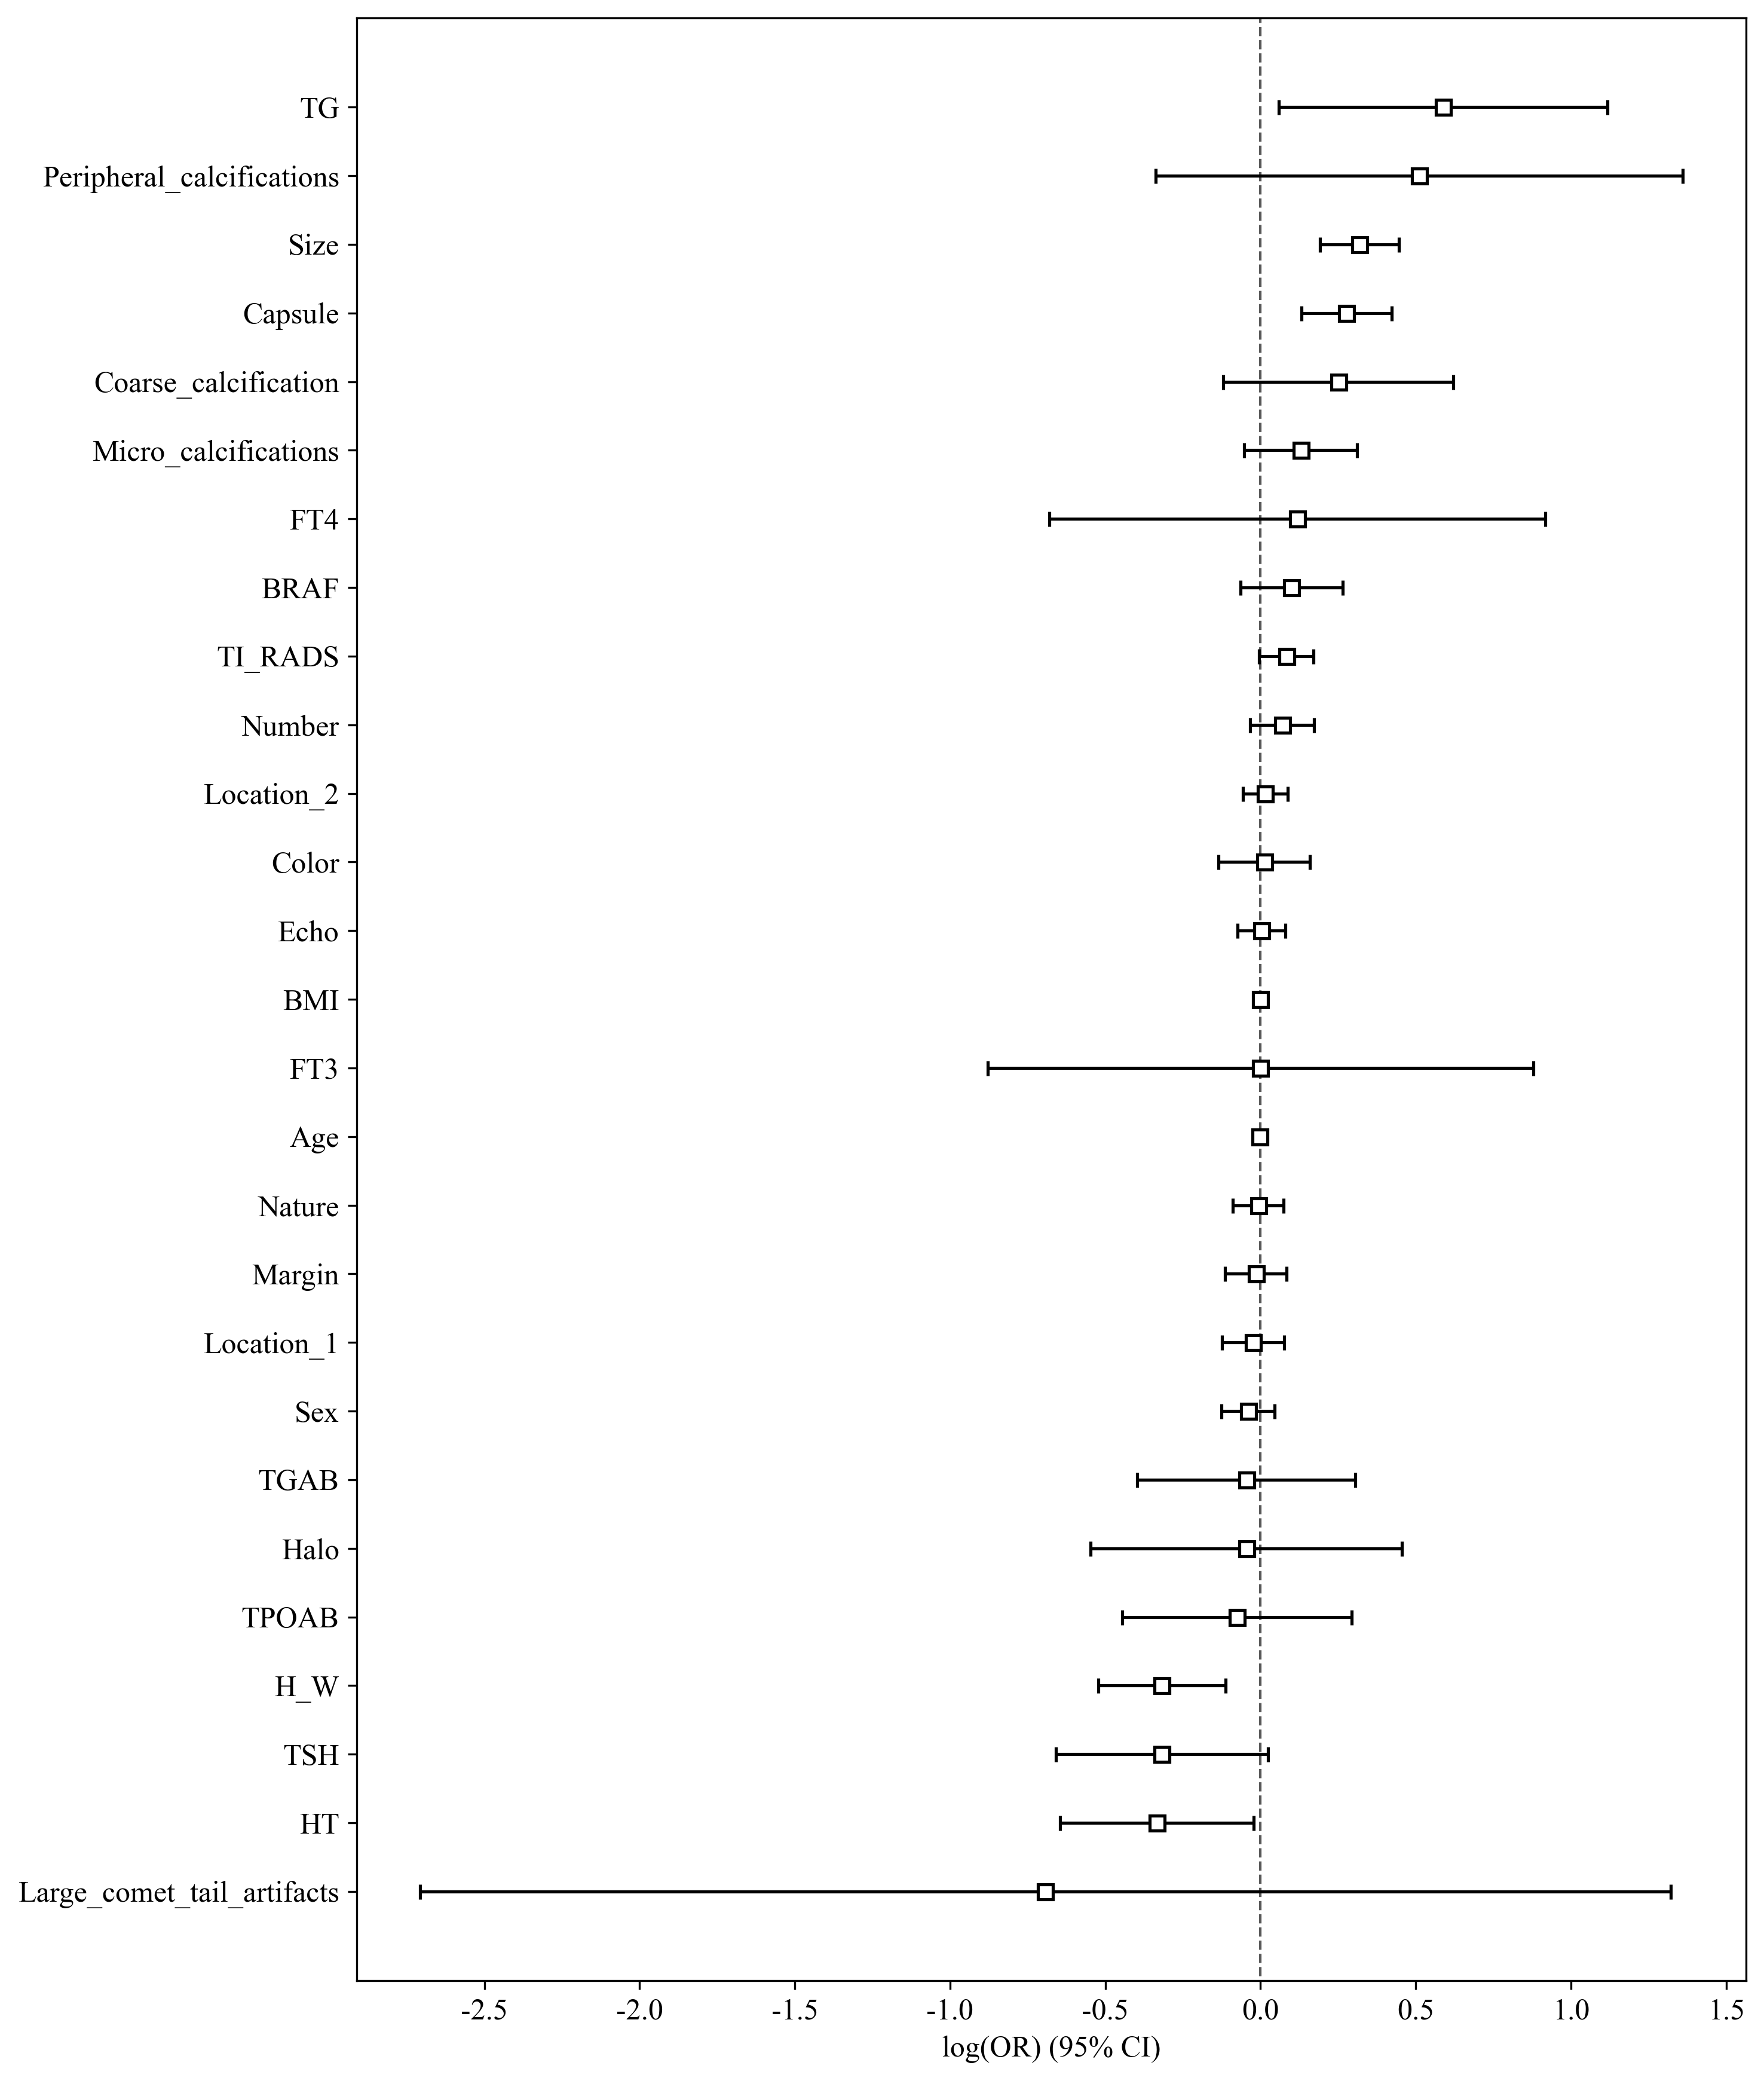

Optimization terminated successfully.
         Current function value: 0.629117
         Iterations 5


,Log(OR),lower 95%CI,upper 95%CI,OR,OR lower 95%CI,OR upper 95%CI,p_value
feature_name,,,,,,,
H_W,-0.997,-1.273,-0.721,0.369,0.280,0.486,0.000
Capsule,0.227,-0.017,0.471,1.255,0.983,1.602,0.125
Size,0.556,0.320,0.791,1.743,1.377,2.206,0.000


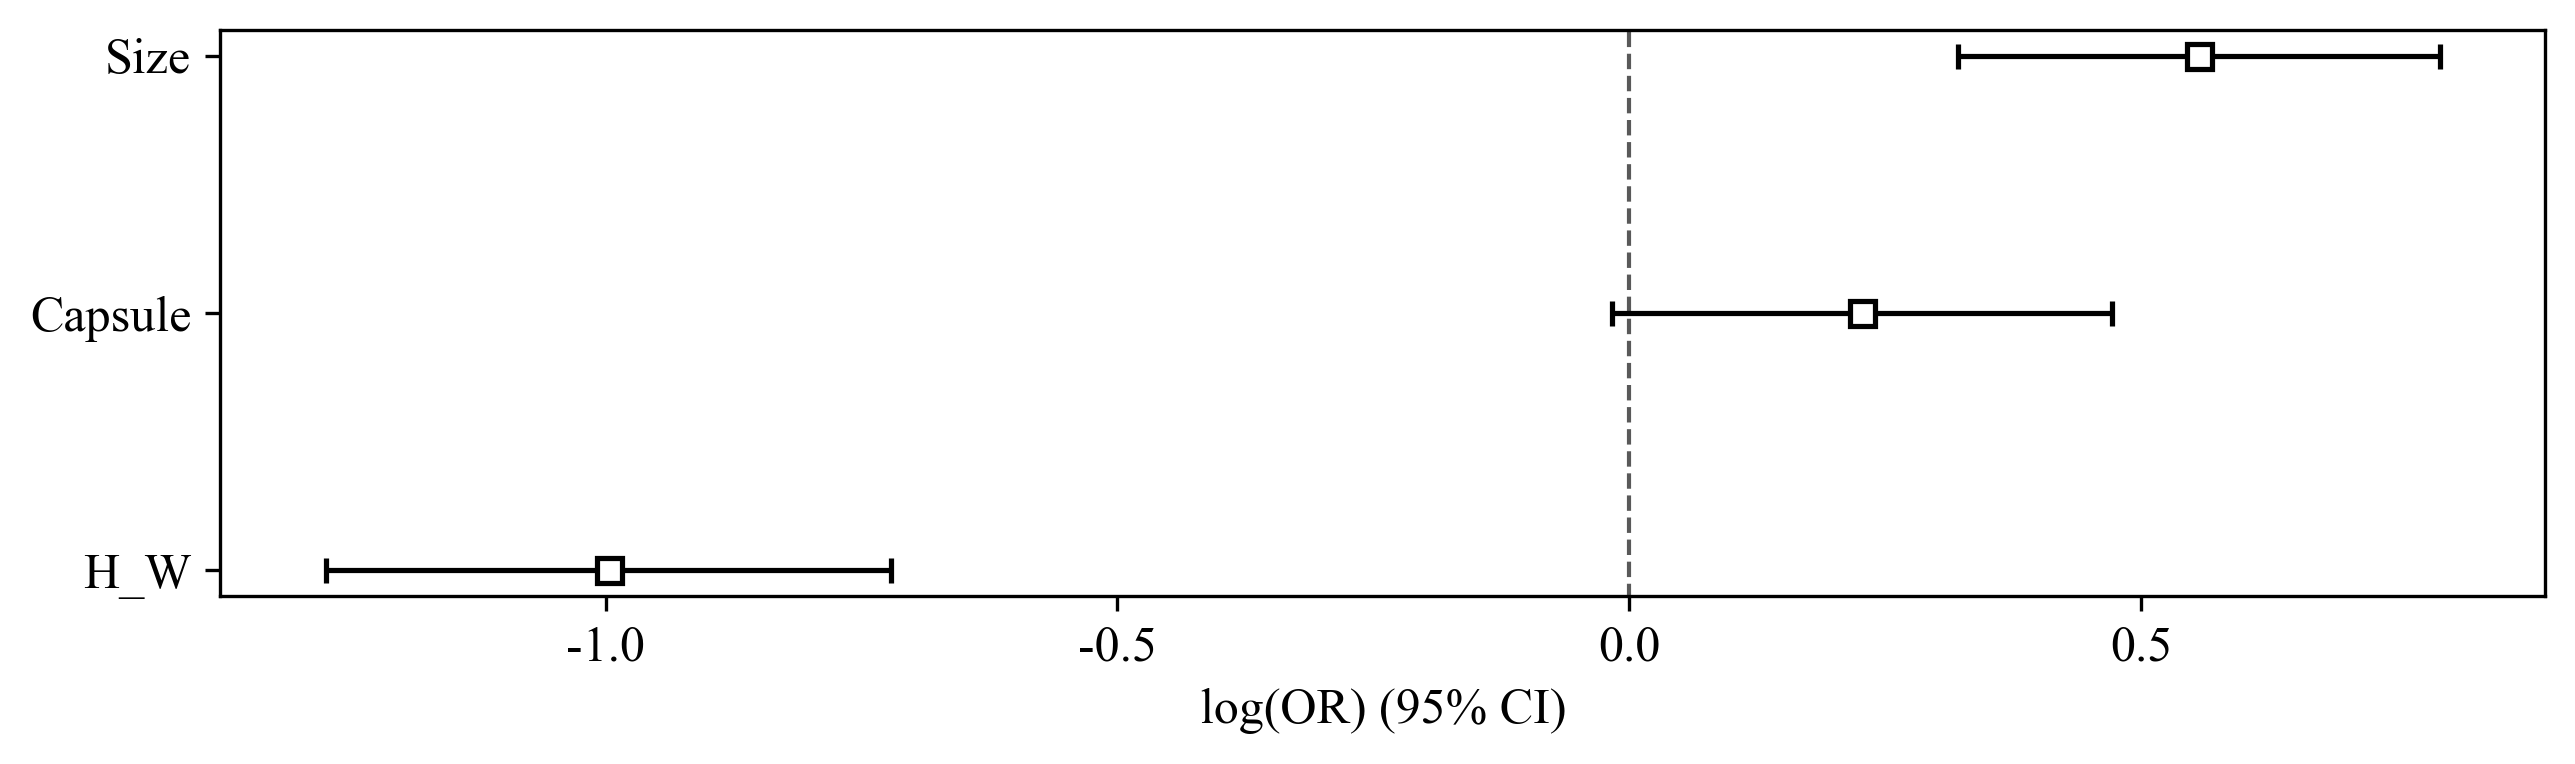

In [10]:
from onekey_algo.custom.components.comp1 import uni_multi_variable_analysis                        

uni_multi_variable_analysis(data[data['group'] == 'train'], stats_columns, save_dir='img', p_value4multi=p_value, algo='logit')

In [11]:
uni_v = pd.read_csv('img/multivariable_reg.csv')
uni_v = uni_v[uni_v['p_value'] <= 0.05]
sel_data = data[['ID'] + list(uni_v['feature_name']) + ['group', 'label']]
sel_data.to_csv('data/clinic_sel.csv', index=False)
sel_data

,ID,H_W,Size,group,label
0,1.nii.gz,0,0.74,train,0
1,2.nii.gz,1,0.58,val,0
2,3.nii.gz,1,0.65,val,0
3,4.nii.gz,1,0.68,train,1
4,5.nii.gz,1,0.76,val,1
5,6.nii.gz,1,0.84,val,0
6,7.nii.gz,1,0.68,train,0
7,8.nii.gz,1,1.23,train,1
8,11.nii.gz,1,2.42,train,0
9,12.nii.gz,1,1.14,train,0


In [12]:
uni = pd.read_csv('img/univariable_reg.csv')
uni = uni[[c for c in uni if ('OR' in c and 'Log' not in c) or c in ['feature_name', 'p_value']]]
multi = pd.read_csv('img/multivariable_reg.csv')
multi = multi[[c for c in uni if ('OR' in c and 'Log' not in c) or c in ['feature_name', 'p_value']]]
info = pd.merge(uni, multi, on='feature_name', how='left', suffixes=['_UNI', '_MULTI']).applymap(lambda x: '' if pd.isna(x) else x)
info.to_csv('results/unimulti.csv', index=False)
info

,feature_name,OR_UNI,OR lower 95%CI_UNI,OR upper 95%CI_UNI,p_value_UNI,OR_MULTI,OR lower 95%CI_MULTI,OR upper 95%CI_MULTI,p_value_MULTI
0,Large_comet_tail_artifacts,0.500,0.067,3.747,0.571,,,,
1,HT,0.716,0.525,0.978,0.078,,,,
2,TSH,0.727,0.517,1.023,0.125,,,,
3,H_W,0.727,0.593,0.892,0.010,0.369,0.28,0.486,0.0
4,TPOAB,0.927,0.640,1.342,0.736,,,,
5,Halo,0.955,0.578,1.576,0.879,,,,
6,TGAB,0.956,0.673,1.357,0.831,,,,
7,Sex,0.961,0.882,1.047,0.449,,,,
8,Location_1,0.977,0.884,1.079,0.695,,,,
9,Margin,0.985,0.892,1.089,0.808,,,,
